# Importing libraries

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


# Loading Data

In [69]:
df = pd.read_csv('/kaggle/input/elecdataaa/Electric_Vehicle_Population_Data.csv')
# Updated dataset'/kaggle/input/datasetev/ElectricCarData_Clean.csv')

# Display first 5 rows
df.head()


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,37.0,477309682,POINT (-122.23825 47.49461),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,5YJYGDEE3L,Kitsap,Poulsbo,WA,98370.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,23.0,109705683,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10
2,KM8KRDAF5P,Kitsap,Olalla,WA,98359.0,2023,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,26.0,230390492,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10
3,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,30.0,0.0,35.0,267929112,POINT (-122.81585 47.64509),PUGET SOUND ENERGY INC,5.303509e+10
4,JTMAB3FV7P,Thurston,Rainier,WA,98576.0,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0,2.0,236505139,POINT (-122.68993 46.88897),PUGET SOUND ENERGY INC,5.306701e+10


# PreProcessing Data

In [70]:
# Check basic information
df.info()
# Summary statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235692 entries, 0 to 235691
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         235692 non-null  object 
 1   County                                             235689 non-null  object 
 2   City                                               235689 non-null  object 
 3   State                                              235692 non-null  object 
 4   Postal Code                                        235689 non-null  float64
 5   Model Year                                         235692 non-null  int64  
 6   Make                                               235692 non-null  object 
 7   Model                                              235692 non-null  object 
 8   Electric Vehicle Type                              235692 non-null  object

,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,235689.000000,235692.000000,235656.000000,235656.000000,235198.000000,2.356920e+05,2.356890e+05
mean,98177.656463,2021.406658,46.262569,787.268328,28.879519,2.353127e+08,5.298066e+10
std,2524.218661,2.991908,84.045829,7177.668305,14.904644,6.799098e+07,1.521066e+09
min,1731.000000,2000.000000,0.000000,0.000000,1.000000,4.385000e+03,1.001020e+09
25%,98052.000000,2020.000000,0.000000,0.000000,17.000000,2.053457e+08,5.303301e+10
50%,98126.000000,2023.000000,0.000000,0.000000,32.000000,2.522795e+08,5.303303e+10
75%,98374.000000,2024.000000,38.000000,0.000000,42.000000,2.696401e+08,5.305307e+10
max,99577.000000,2025.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.602100e+10


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])


Missing values per column:
 County                    3
City                      3
Postal Code               3
Electric Range           36
Base MSRP                36
Legislative District    494
Vehicle Location         10
Electric Utility          3
2020 Census Tract         3
dtype: int64


In [71]:
# Fill missing numerical values with the median
df["Electric Range"] = df["Electric Range"].fillna(df["Electric Range"].median())
df["Base MSRP"] = df["Base MSRP"].fillna(df["Base MSRP"].median())

# Drop rows with missing categorical values
df = df.dropna(subset=["County", "City", "State", "Electric Utility"])




In [72]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
categorical_cols = ["County", "City", "State", "Make", "Model", "Electric Vehicle Type", 
                    "Clean Alternative Fuel Vehicle (CAFV) Eligibility", "Electric Utility"]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store encoders for later use


# Removing Outliers

In [73]:
# Define numerical columns
numerical_cols = ["Model Year", "Electric Range", "Base MSRP"]

# Remove outliers using IQR
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


# Visualization & Analytics

<Figure size 1000x500 with 0 Axes>

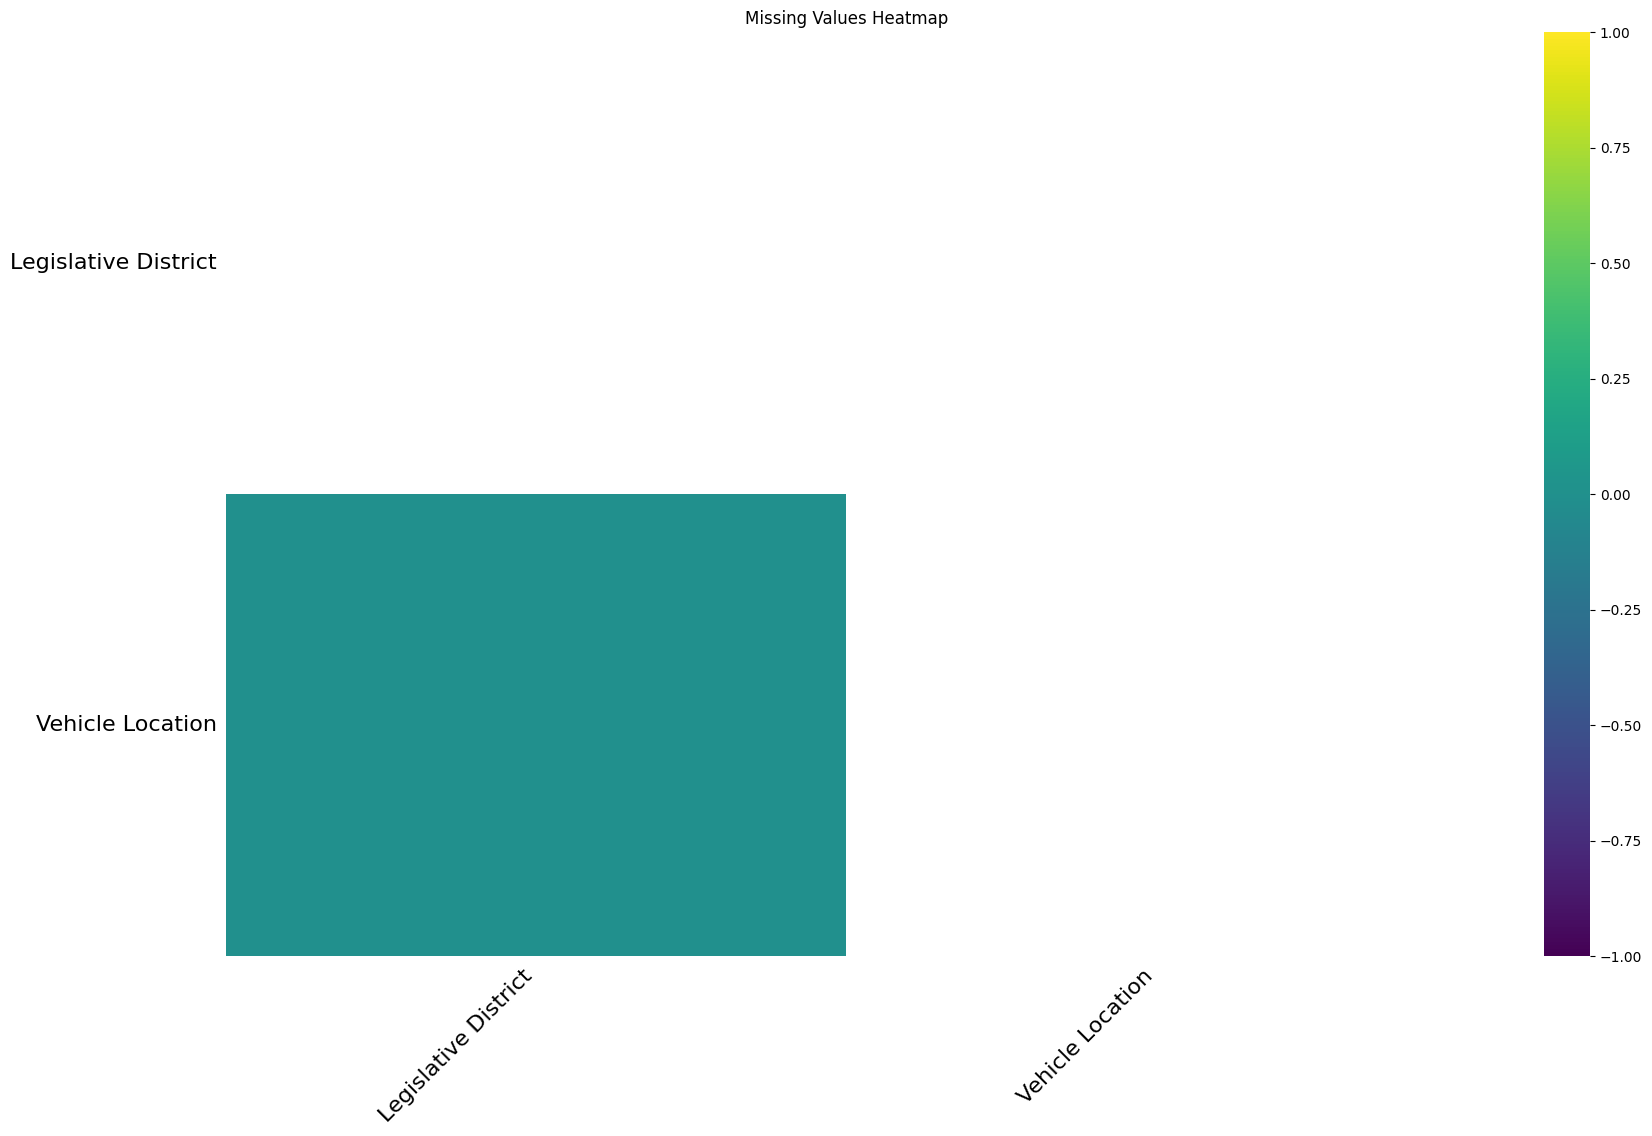

In [74]:
import missingno as msno

plt.figure(figsize=(10, 5))
msno.heatmap(df, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


In [58]:
print(df.columns)


Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')


In [75]:
print(df['Model Year'][:10])

2     2023
3     2021
4     2023
6     2017
7     2022
10    2014
12    2019
16    2016
17    2015
18    2022
Name: Model Year, dtype: int64


# Trend Analysis of EV Adoption Over Time

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


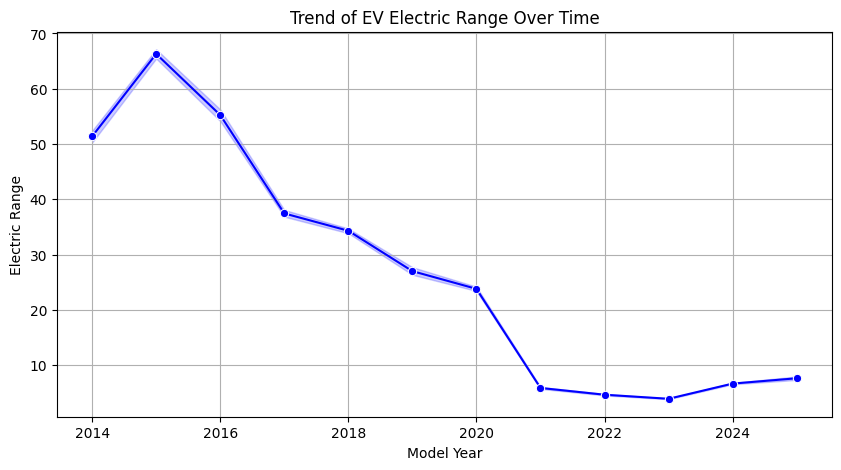

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Model Year', y='Electric Range', marker='o', color='b')
plt.title("Trend of EV Electric Range Over Time")
plt.xlabel("Model Year")
plt.ylabel("Electric Range")
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


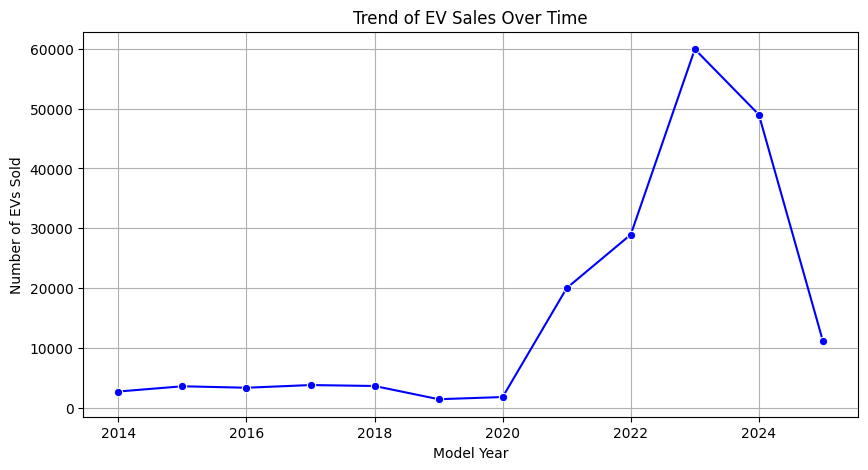

In [77]:
ev_sales_by_year = df.groupby('Model Year').size().reset_index(name='EV Sales')

plt.figure(figsize=(10, 5))
sns.lineplot(data=ev_sales_by_year, x='Model Year', y='EV Sales', marker='o', color='b')
plt.title("Trend of EV Sales Over Time")
plt.xlabel("Model Year")
plt.ylabel("Number of EVs Sold")
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


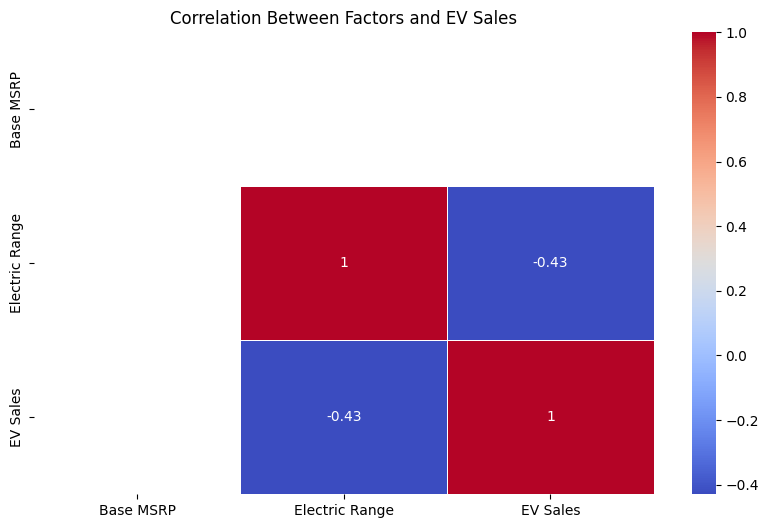

In [78]:
import numpy as np

# Select key influencing factors
factors = ["Base MSRP", "Electric Range"]
df["EV Sales"] = df.groupby("Model Year")["Model Year"].transform("count")  

# Pairwise correlation with EV Sales
correlations = df[factors + ["EV Sales"]].corr()

# Heatmap of correlation
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Factors and EV Sales")
plt.show()


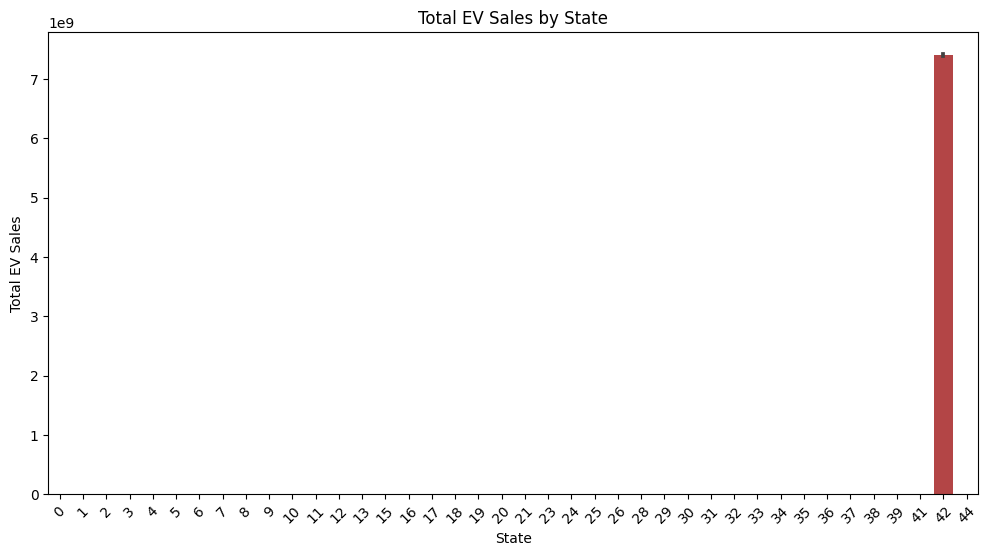

In [79]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="State", y="EV Sales", estimator=sum, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Total EV Sales by State")
plt.xlabel("State")
plt.ylabel("Total EV Sales")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


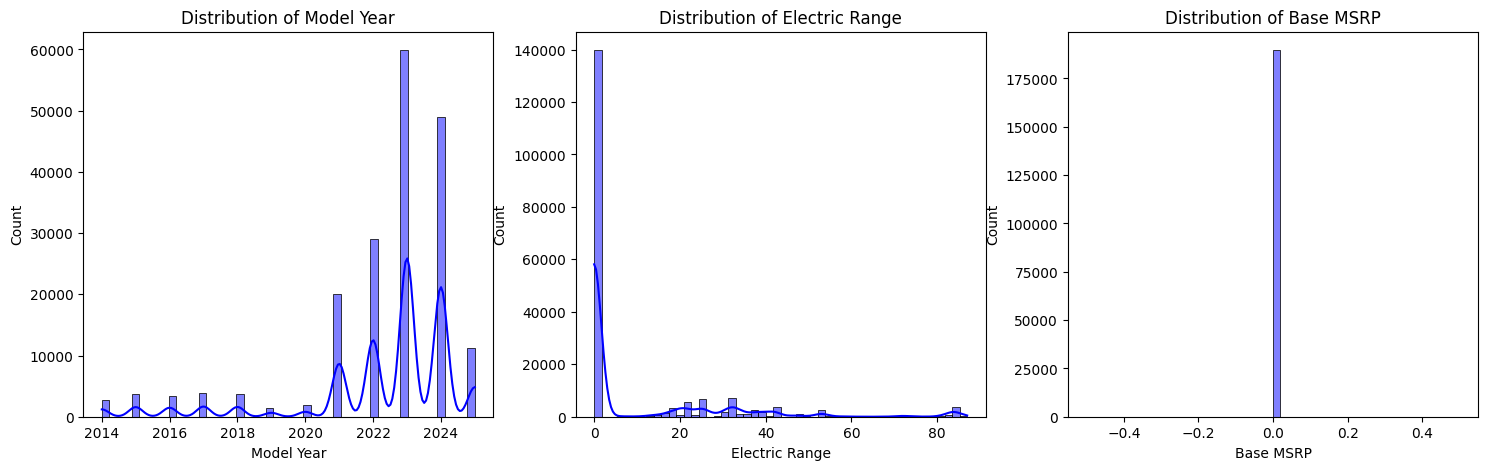

In [80]:
numerical_cols = ["Model Year", "Electric Range", "Base MSRP"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {col}")

plt.show()


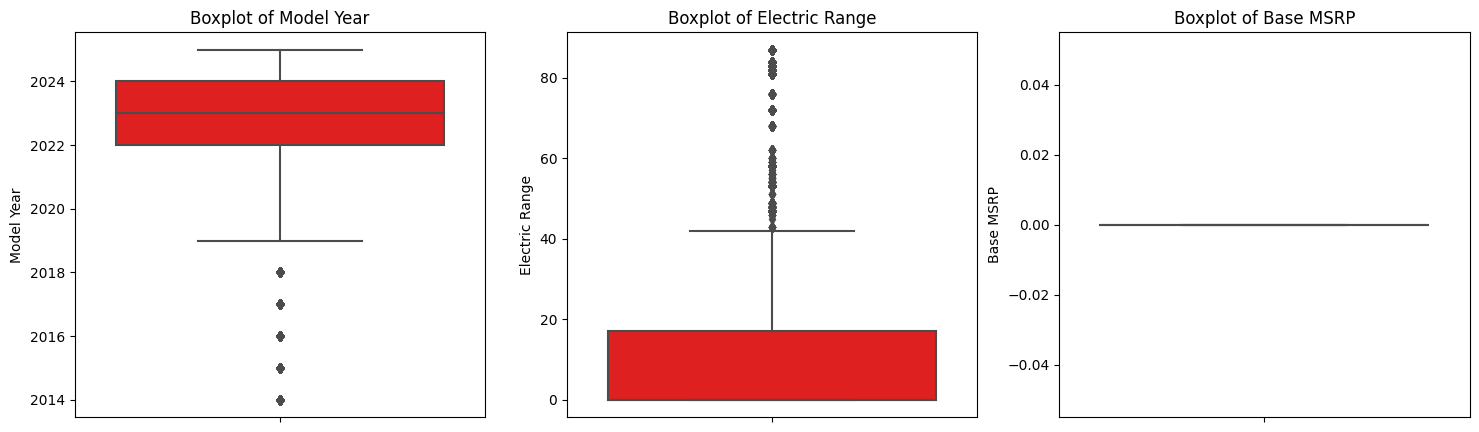

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i], color="red")
    axes[i].set_title(f"Boxplot of {col}")

plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


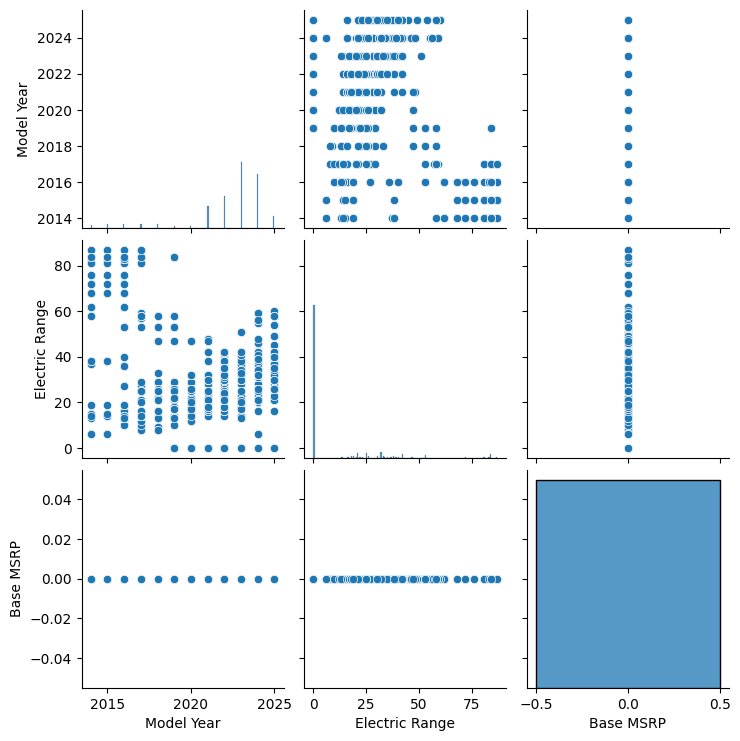

In [82]:
sns.pairplot(df[numerical_cols])
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


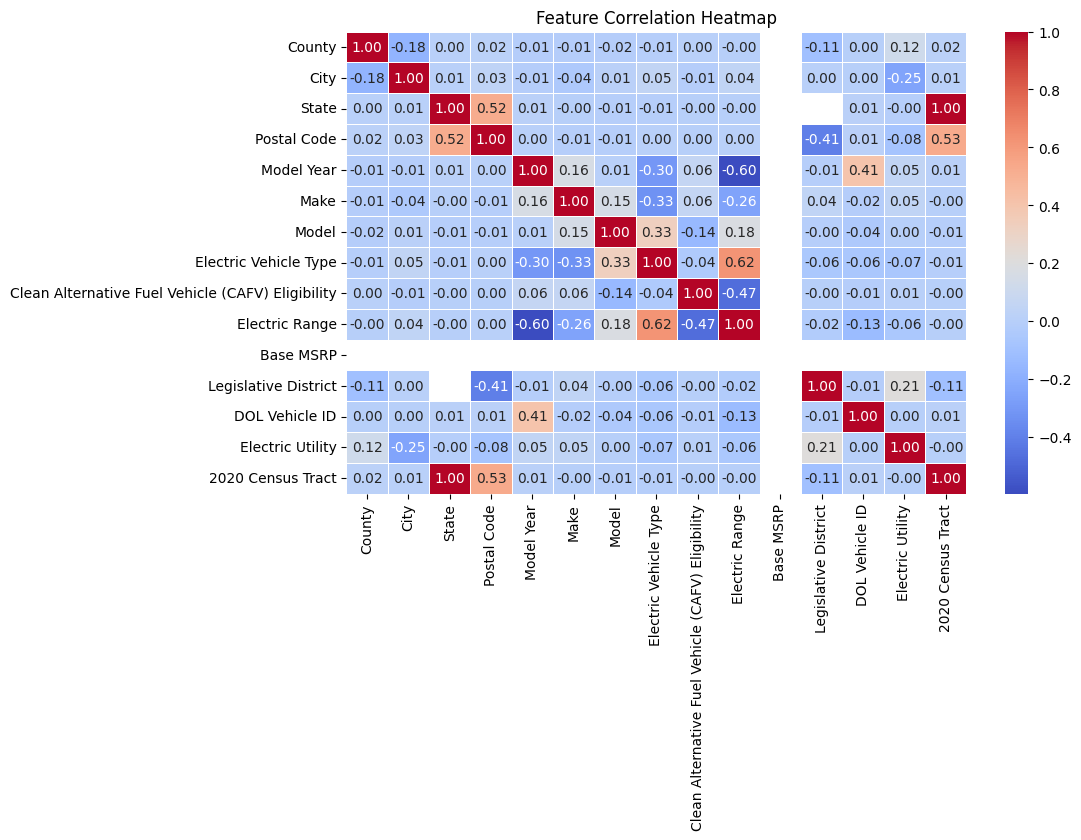

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
